In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.stats import norm
from arch import arch_model


In [5]:
df = pd.read_csv('/Users/philiplacava/Projects/DSCI 521/Bubble project/Asset-Price-Bubble-Detection/Merged Monthly Stock Data1.csv')
#df = pd.read_csv("/Users/philiplacava/Projects/DSCI 521/Bubble project/Asset-Price-Bubble-Detection/Merged Monthly Stock Data.csv")
df1 = pd.read_csv('/Users/philiplacava/Projects/DSCI 521/Bubble project/Asset-Price-Bubble-Detection/JSE Main Market Index Price (Elections).csv')

df = df.dropna()
df1 = df1.drop(303)
#df=df.drop(303)
df.tail()
df.columns
df = df[::-1]
df1 = df1[::-1]



In [6]:
# Convert 'bovprice' and 'snpprice' to numeric types
df['bovprice'] = df['bovprice'].str.replace(',', '').astype(float)
df['snpprice'] = df['snpprice'].str.replace(',', '').astype(float)
df['bovreturn'] = df['bovreturn'].str.replace('%', '').astype(float)
df['snpreturn'] = df['snpreturn'].str.replace('%', '').astype(float)
bprice = df['bovprice']
sprice = df['snpprice']
breturn = df['bovreturn']
sreturn = df['snpreturn']
bfore = df['before_election']
after = df['after_election']
election = df['election_month']


In [7]:
df1['Returns_JM'] = df1['Returns_JM'].str.replace('%', '').astype(float)
sreturn1 = df1['SPX Index  (L1)'].pct_change() * 100
jprice = df1['JMSMX Index  (R1)']
sprice1 = df1['SPX Index  (L1)']
jreturn = df1['Returns_JM']

In [8]:
T = len(df['Date'])
T

304

In [9]:
# Reverse the order of the dataframe (it was upside down)
date = pd.date_range(start='1999-01-01', periods=T, freq='1m')




/var/folders/gj/ntyx2j3d1rdf_dqn_fckn5pr0000gn/T/ipykernel_26821/3416237925.py:2: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  date = pd.date_range(start='1999-01-01', periods=T, freq='1m')


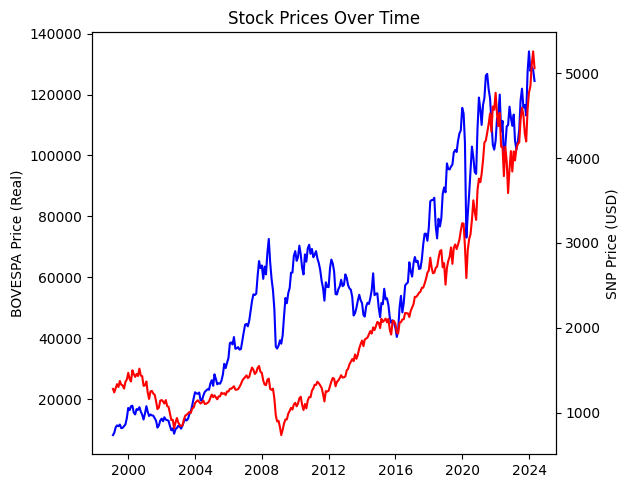

In [10]:
# Plotting
fig, ax1 = plt.subplots()

# Plot 'bovprice' on the primary y-axis
ax1.plot(date, bprice, color='blue', label='BOV Price')
ax1.set_ylabel('BOVESPA Price (Real)')

# Create a secondary y-axis for 'snpprice'
ax2 = ax1.twinx()
ax2.plot(date,sprice, color='red', label='SNP Price')
ax2.set_ylabel('SNP Price (USD)')

plt.tight_layout()
plt.title('Stock Prices Over Time')
plt.show()

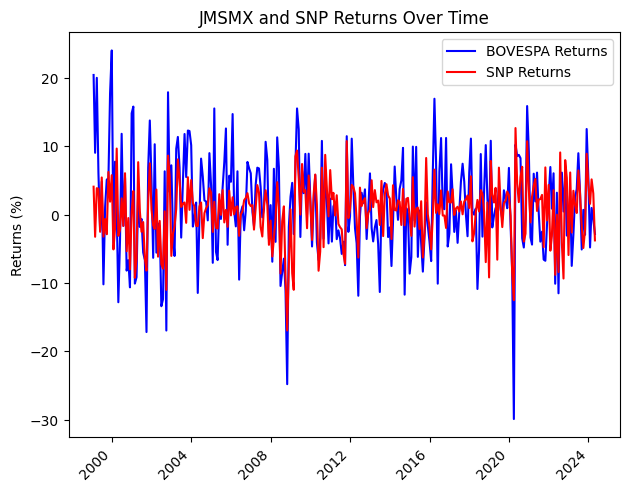

In [22]:

# Plotting BOV Returns and SNP Returns on the same graph
fig, ax = plt.subplots()
ax.plot(date, breturn, color='blue', label='BOVESPA Returns')
ax.plot(date, sreturn, color='red', label='SNP Returns')
ax.set_ylabel('Returns (%)')
plt.xticks(rotation=45, ha='right')  # Format x-axis labels
plt.tight_layout()
plt.title('JMSMX and SNP Returns Over Time')
plt.legend()
plt.show()


<Figure size 1000x500 with 0 Axes>

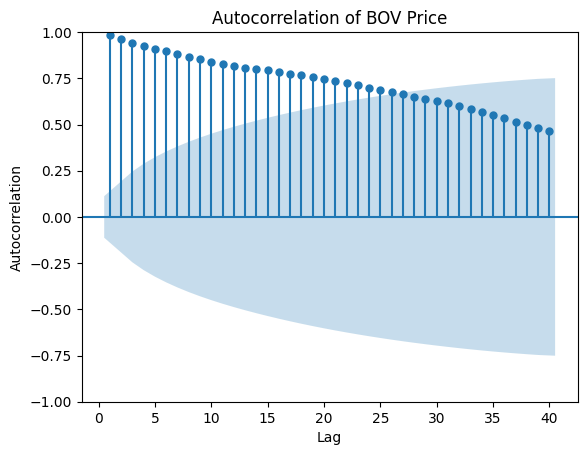

<Figure size 1000x500 with 0 Axes>

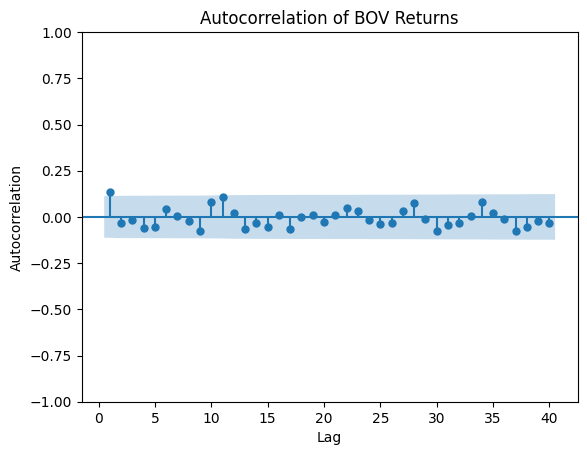

<Figure size 1000x500 with 0 Axes>

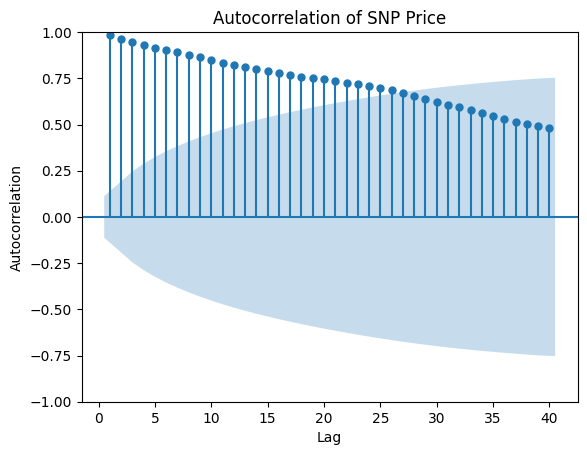

<Figure size 1000x500 with 0 Axes>

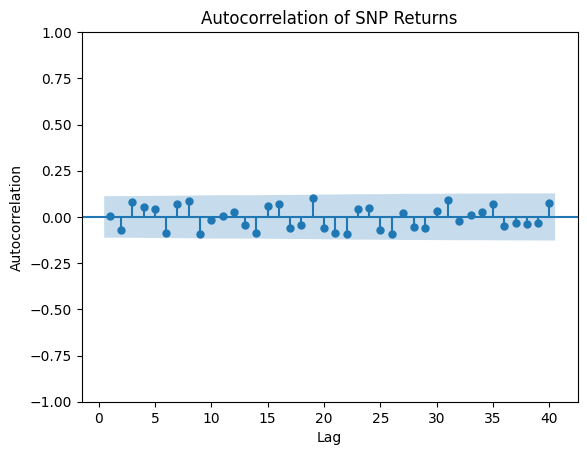

In [23]:
# Plot Correlogram for BOV Price
plt.figure(figsize=(10, 5))
plot_acf(bprice, lags=40, zero=False, title='Autocorrelation of BOV Price')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot Correlogram for BOV Returns
plt.figure(figsize=(10, 5))
plot_acf(breturn.dropna(), lags=40, zero=False, title='Autocorrelation of BOV Returns')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot Correlogram for SNP Price
plt.figure(figsize=(10, 5))
plot_acf(sprice, lags=40, zero=False, title='Autocorrelation of SNP Price')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot Correlogram for SNP Returns
plt.figure(figsize=(10, 5))
plot_acf(sreturn.dropna(), lags=40, zero=False, title='Autocorrelation of SNP Returns')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

ADF Statistic: -12.119517649892703
p-value: 1.8390674113899946e-22
Critical Values:
	1%: -3.4521902441030963
	5%: -2.871158406898617
	10%: -2.5718948388228586
                            AutoReg Model Results                             
Dep. Variable:              bovreturn   No. Observations:                  304
Model:                     AutoReg(1)   Log Likelihood               -1025.584
Method:               Conditional MLE   S.D. of innovations              7.141
Date:                Sat, 04 May 2024   AIC                           2057.168
Time:                        03:23:28   BIC                           2068.309
Sample:                             1   HQIC                          2061.625
                                  304                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.9966      0.416      2.395  

/Users/philiplacava/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


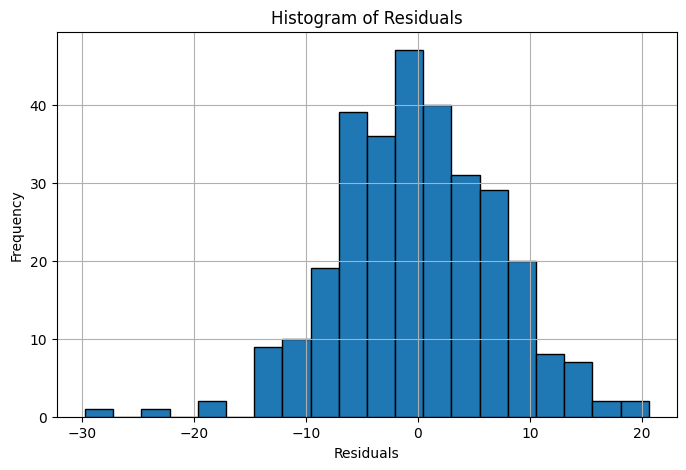

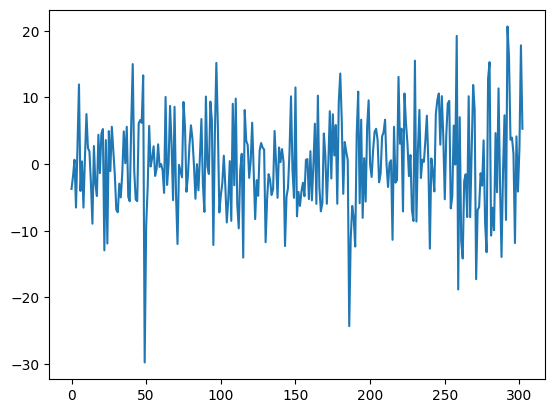

In [14]:
# White noise conditions
result = adfuller(breturn, regression ='c')
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')
    """
    Run Augmented Dickey-Fuller test on a given series.

    Parameters:
    series (pd.Series): Time series data.
    regression_type (str): Type of regression ('c', 'ct', 'ctt', 'nc') to include in the test.
                           'c' - Constant only (default)
                           'ct' - Constant and trend
                           'ctt' - Constant, linear and quadratic trend
                           'nc' - No constant, no trend
    """
# Define lag order (p) for the AR model
p = 1 # Example lag order
# Fit AR model
model = AutoReg(breturn, lags=p)
results = model.fit()

# Print model summary
print(results.summary())
std_dev = breturn.std()
print(f'Standard Deviation of bovreturn: {std_dev}')

residuals = results.resid
squaredresids = residuals**2 

# Plot histogram of residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=20, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid(True)
plt.show()

plt.plot(residuals)

In [ ]:
# Arch
model = AutoReg(squaredresids, lags=p)
results = model.fit()
print(results.summary())


                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  303
Model:                     AutoReg(1)   Log Likelihood               -1772.639
Method:               Conditional MLE   S.D. of innovations             85.689
Date:                Fri, 03 May 2024   AIC                           3551.278
Time:                        22:59:13   BIC                           3562.409
Sample:                             1   HQIC                          3555.731
                                  303                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.6746      5.721      7.459      0.000      31.461      53.888
y.L1           0.1642      0.057      2.892      0.004       0.053       0.275
                                    Roots           

/Users/philiplacava/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [15]:
# Creating a DataFrame for the election data to use as an exogenous regressor
X = pd.DataFrame({'election': election, 'before': bfore, 'after': after})

# Define the model with ARX mean and GARCH(1,1) volatility
model = arch_model(breturn, x=X, mean='ARX', lags=1, vol='GARCH', p=1, q=1, dist='normal')

# Fit the model
results = model.fit(
    update_freq=5,            # How frequently to update about the optimization process
    disp='final',             # Display final results
    tol=0.0001,               # Set the tolerance for termination
    options={'maxiter': 1000, 'disp': True},  # Increase max iterations and display iterations
    cov_type='robust'        # Classic is Bollerslev-Wooldridge covariance estimator. Robust assumes nothing
)

# Print the summary of the model
print(results.summary())


Iteration:      5,   Func. Count:     53,   Neg. LLF: 1017.0015507106053
Iteration:     10,   Func. Count:     98,   Neg. LLF: 1016.9588935666382
Iteration:     15,   Func. Count:    143,   Neg. LLF: 1016.9208331112663
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1016.9045309627934
            Iterations: 19
            Function evaluations: 178
            Gradient evaluations: 19
                          AR-X - GARCH Model Results                          
Dep. Variable:              bovreturn   R-squared:                       0.038
Mean Model:                      AR-X   Adj. R-squared:                  0.025
Vol Model:                      GARCH   Log-Likelihood:               -1016.90
Distribution:                  Normal   AIC:                           2049.81
Method:            Maximum Likelihood   BIC:                           2079.52
                                        No. Observations:                  303
Date:            

In [16]:
# Initial settings for the SADF test window
r0 = 0.01 + 1.8 / np.sqrt(T)
swindow0 = int(np.floor(r0 * T))
dim = T - swindow0 + 1

def simulate_critical_values(num_simulations, T, r0):
    critical_values = []
    for _ in range(num_simulations):
        # Generate a unit root process
        series = np.random.normal(size=T).cumsum()
        # Placeholder for SADF/GSADF calculation: this should ideally be replaced
        # with a function that calculates the SADF/GSADF statistic.
        stat = adfuller(series, maxlag=int(r0*T), regression='c', autolag=None)[0]
        critical_values.append(stat)
    
    # Determine the 90%, 95%, and 99% critical values
    critical_values = np.percentile(critical_values, [90, 95, 99])
    return critical_values

# Example usage
num_simulations = 2000

critical_values = simulate_critical_values(num_simulations, T, r0)
print("Critical values at 90%, 95%, 99%:", critical_values)


Critical values at 90%, 95%, 99%: [-0.2144932   0.26405325  1.17088225]


In [17]:
# Calculate the SADF statistic
dateS = date[swindow0:]

badfs = np.zeros(dim)
for i in range(swindow0, T):
    result = adfuller(df['bovprice'][:i+1], maxlag=2, regression='c', autolag=None)
    badfs[i - swindow0] = result[0]
sadf = np.max(badfs)

print('The SADF statistic:', sadf)
print('The critical values:', critical_values)

The SADF statistic: 3.1092338845673577
The critical values: [-0.2144932   0.26405325  1.17088225]


In [18]:
# Calculate the Generalized SADF statistic
bsadfs = np.zeros(dim)
for r2 in range(swindow0, T):
    dim0 = r2 - swindow0 + 1
    rwadft = np.zeros(dim0)
    for r1 in range(dim0):
        result = adfuller(df['bovprice'][r1:r2+1], maxlag=2, regression='c', autolag=None)
        rwadft[r1] = result[0]
    bsadfs[r2 - swindow0] = np.max(rwadft)

gsadf = np.max(bsadfs)

print('The GSADF statistic:', gsadf)
print('The critical values:', critical_values)

The GSADF statistic: 3.378918732431357
The critical values: [-0.2144932   0.26405325  1.17088225]


In [19]:
print(len(dateS), len(bsadfs), len(badfs)) 


270 271 271


In [20]:
# Removing excess values not in the date range
badfs_plt = badfs[:-1]
bsadfs_plt = bsadfs[:-1]


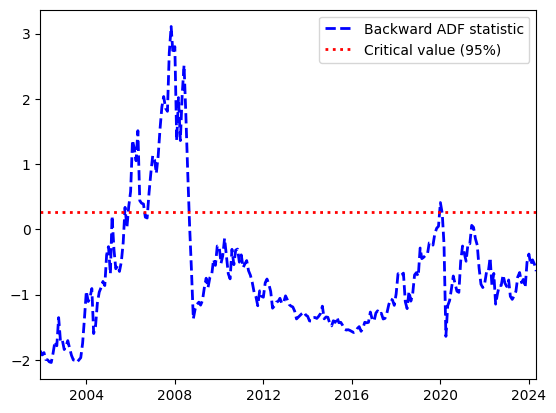

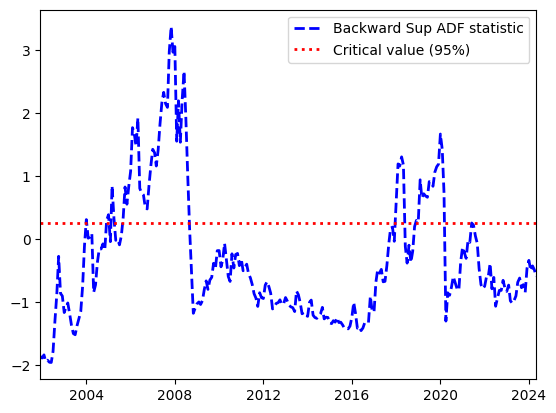

In [21]:
# Plot the backward ADF statistics
plt.figure(1)
plt.plot(dateS, badfs_plt, '--b', linewidth=2)
plt.plot(dateS, [critical_values[1]]*len(dateS), ':r', linewidth=2)
plt.xlim([dateS[0], dateS[-1]])
plt.legend(['Backward ADF statistic', 'Critical value (95%)'])



# Plot the Generalized SADF statistics
plt.figure(2)
plt.plot(dateS, bsadfs_plt, '--b', linewidth=2)
plt.plot(dateS, [critical_values[1]]*len(dateS), ':r', linewidth=2)
plt.xlim([dateS[0], dateS[-1]])
plt.legend(['Backward Sup ADF statistic', 'Critical value (95%)'])
